# Static analysis of a 2d console under a concentrated load as a membrane | Q9_M

In [1]:
# GEOMETRY
Lx = 50.0  # length of the domain in X direction
Ly = 10.0  # length of the domain in Y direction
t = 1.0  # thickness of the domain

# FEM DISCRETIZATION
nx = 25  # number of finite elements in X direction
ny = 5  # number of finite elements in Y direction

# MATERIAL
E = 12000.0  # Young's elastic modulus
nu = 0.2  # Poisson's ratio
yield_strength = 100.0

# LOADS
Fy = -25.0  # vertical load at the free end

## Define a Mesh

In [2]:
from sigmaepsilon.mesh import grid
import numpy as np

coords, topo = grid(size=(Lx, Ly), shape=(nx, ny), eshape="Q9")

## Define a Material

For simple purposes the material can be a NumPy array, but it comes with advantages to define a proper material using the machincery in `sigmaepsilon.solid.material` like being able to calculate utilizations and material stresses.

In [3]:
from sigmaepsilon.solid.material import MembraneSection as Section
from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_M,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

array = elastic_stiffness_matrix(E=E, NU=nu)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(array, frame=frame, tensorial=False)
failure_model = HuberMisesHenckyFailureCriterion_M(yield_strength=yield_strength)
material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

section = Section(
    layers=[
        Section.Layer(material=material, thickness=t),
    ]
)

## Set Boundary Conditions

In [4]:
from sigmaepsilon.mesh.utils.space import index_of_closest_point

cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 2), dtype=bool)
fixity[ebcinds, :] = True

loads = np.zeros((coords.shape[0], fixity.shape[1]))
loadindex = index_of_closest_point(coords, np.array([Lx, Ly / 2, 0]))
loads[loadindex, 1] = Fy

## Assembly and Solution

In [5]:
from sigmaepsilon.mesh.space import StandardFrame
from sigmaepsilon.solid.fem import Structure, PointData, MembraneMesh as Mesh
from sigmaepsilon.solid.fem.cells import Q9_M as CellData

GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
cd = CellData(topo=topo, material=section, frames=GlobalFrame.show())
mesh = Mesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)

structure.linear_static_analysis()

## Postprocessing

Calculate model stresses (internal forces and moments)

In [6]:
dofsol = structure.nodal_dof_solution()

points = CellData.Geometry.master_coordinates()
internal_forces_fem = cd.internal_forces(points=points, flatten=False)
cd.db["scalars"] = internal_forces_fem[:, :, 0, 0]
nx_fem = pd.pull("scalars")
cd.db["scalars"] = internal_forces_fem[:, :, 1, 0]
ny_fem = pd.pull("scalars")
cd.db["scalars"] = internal_forces_fem[:, :, 2, 0]
nxy_fem = pd.pull("scalars")

del internal_forces_fem

Calculate model strains

In [7]:
points = CellData.Geometry.master_coordinates()
strains_fem = cd.strains(points=points, flatten=False)
cd.db["scalars"] = strains_fem[:, :, 0, 0]
exx_fem = pd.pull("scalars")
cd.db["scalars"] = strains_fem[:, :, 1, 0]
eyy_fem = pd.pull("scalars")
cd.db["scalars"] = strains_fem[:, :, 2, 0]
exy_fem = pd.pull("scalars")

del strains_fem

Calculate utilization

In [8]:
util_fem = cd.utilization(points=points, z=[0.0])
cd.db["scalars"] = util_fem[:, :, 0]
util_fem = pd.pull("scalars")

In [11]:
mesh.maximum_utilization()

0.86993205386776

## Triangulate and Plot

In [12]:
from sigmaepsilon.mesh.utils.topology import Q9_to_Q4, Q4_to_T3
from sigmaepsilon.mesh import triangulate

tr = lambda c, t : Q4_to_T3(*Q9_to_Q4(c, t))
points, triangles = tr(coords, topo)
x = points[:, :2] + dofsol[:, :2]
triobj = triangulate(points=x, triangles=triangles)[-1]

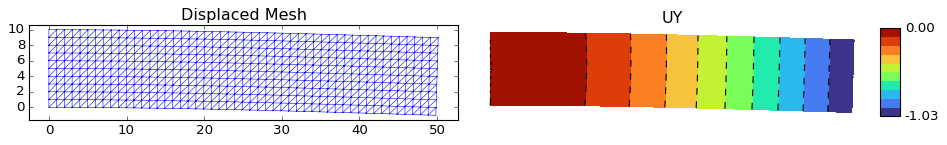

In [13]:
from sigmaepsilon.mesh.plotting import triplot_mpl_mesh, triplot_mpl_data
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.style.use("classic")

fig = plt.figure(figsize=(12, 6))  # in inches
fig.patch.set_facecolor("white")
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
triplot_mpl_mesh(triobj, ax=ax1, fig=fig)
triplot_mpl_data(
    triobj,
    ax=ax2,
    fig=fig,
    data=dofsol[:, 1],
    cmap="turbo",
    axis="off",
    nlevels=10,
    refine=True,
    contour_colors="k",
    draw_contours=True,
)
ax1.set_title("Displaced Mesh")
ax2.set_title("UY")
fig.tight_layout()

In [14]:
from numpy import ndarray
from sigmaepsilon.mesh.plotting import triplot_mpl_data


def plot_solution(fem_data: ndarray, title: str):
    fig = plt.figure(figsize=(12, 4))  # in inches
    fig.patch.set_facecolor("white")
    gs = gridspec.GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(title)
    triplot_mpl_data(
        triobj,
        ax=ax1,
        fig=fig,
        data=fem_data,
        cmap="turbo",
        axis="off",
        cbsize="5%",
        cbpad="2%",
        nlevels=10,
        contour_colors="k",
        draw_contours=True,
    )
    fig.tight_layout()

### Displacement solution

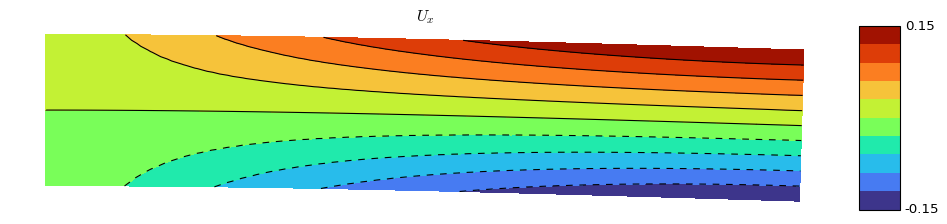

In [15]:
plot_solution(dofsol[:, 0], r"$U_x$")

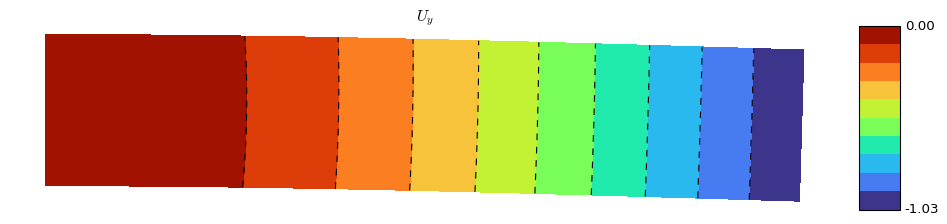

In [16]:
plot_solution(dofsol[:, 1], r"$U_y$")

### Strains

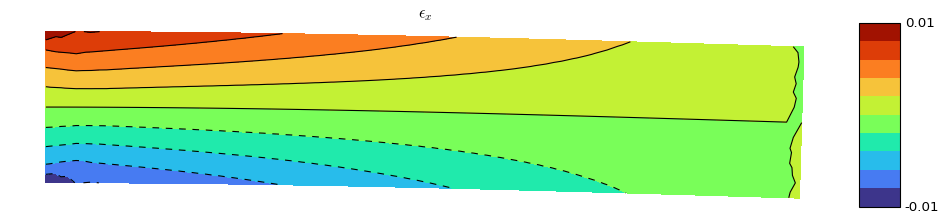

In [17]:
plot_solution(exx_fem, r"$\epsilon_x$")

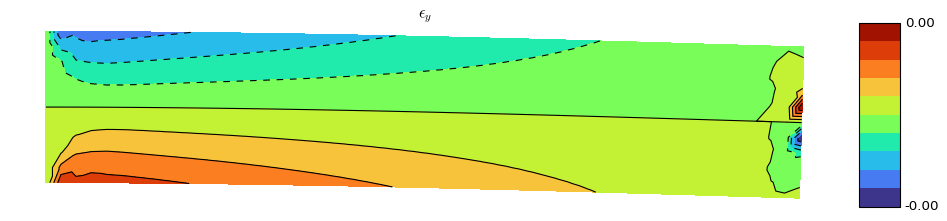

In [18]:
plot_solution(eyy_fem, r"$\epsilon_y$")

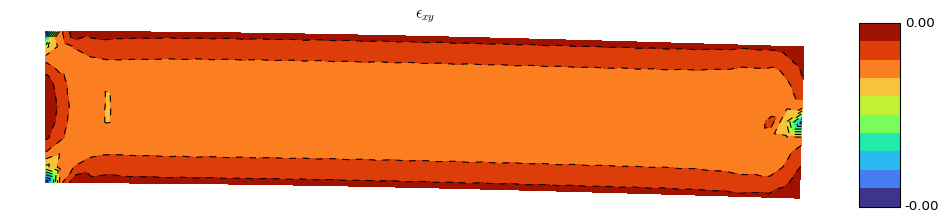

In [19]:
plot_solution(exy_fem, r"$\epsilon_{xy}$")

### Internal forces

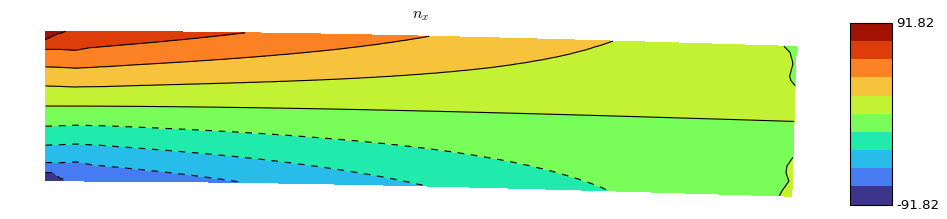

In [20]:
plot_solution(nx_fem, r"$n_{x}$")

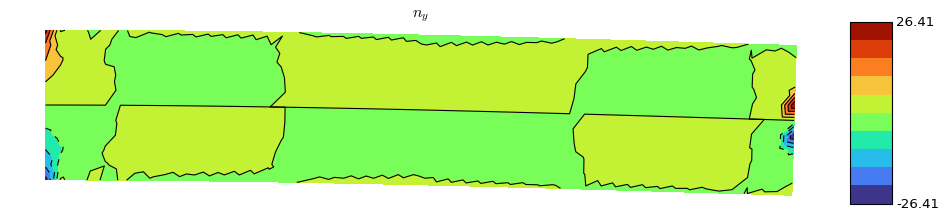

In [21]:
plot_solution(ny_fem, r"$n_{y}$")

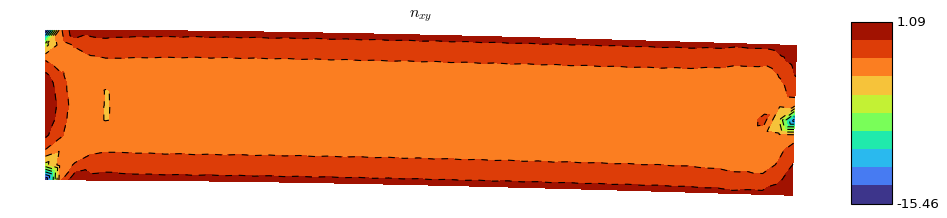

In [22]:
plot_solution(nxy_fem, r"$n_{xy}$")

### Utilization

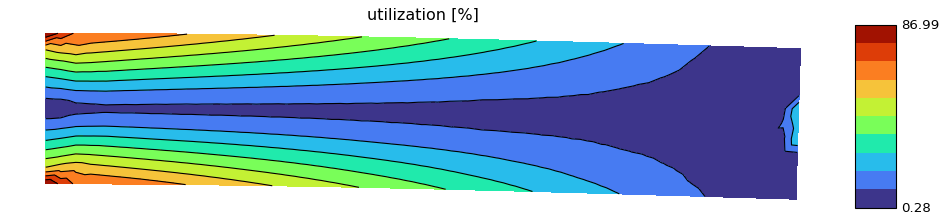

In [23]:
plot_solution(util_fem*100, r"utilization [%]")